In [1]:
import numpy as np
from numpy import tanh
import sys

import matplotlib.pyplot as plt

plt.style.use('paper.mplstyle')
np.set_printoptions(threshold=200, linewidth=200)
plt.figure(figsize=(12,6))

def XI_KB() :
    global METHOD, A, H, KAPPA
    if METHOD == "GALERKIN" :
        return 0
    elif METHOD == "SUPG" :
        if KAPPA != 0 :
            alpha_h = A * H / 2 / KAPPA      
            return 1/tanh(alpha_h) - 1/alpha_h
        else:
            return 1
    elif METHOD == "UPWIND" :
        return 1
    else :
        fail(f"XI(): Unknown method {METHOD}")

def XI_F( ) :
    global METHOD, A, H, KAPPA
    if METHOD == "GALERKIN" :
        return 0
    elif METHOD == "SUPG" :
        if KAPPA != 0 :
            alpha_h = A * H / 2 / KAPPA      
            return 1/tanh(alpha_h) - 1/alpha_h
        else:
            return 1
    elif METHOD == "UPWIND" :
        return 0
    else :
        fail(f"XI(): Unknown method {METHOD}")


def Usolve() :
    global KAPPA, H, A, N, F, G0, G1

    Sdif = np.array( [ -1, 2, -1 ] )
    Sadv = np.array( [ -1, 0, 1] )
    
    K  = np.zeros( [ N-1, N-1 ] )
    B0 = np.zeros( N-1 )
    BN = np.zeros( N-1 )
 
    xi = XI_KB()
    B0[0]   = - ( KAPPA + A*H/2*xi )/H - A/2
    BN[N-2] = - ( KAPPA + A*H/2*xi )/H + A/2 

    K[0,0]     = 2*( KAPPA + A*H/2*xi )/H
    K[0,1]     = - ( KAPPA + A*H/2*xi )/H + A/2
    K[N-2,N-3] = - ( KAPPA + A*H/2*xi )/H - A/2  
    K[N-2,N-2] = 2*( KAPPA + A*H/2*xi )/H

    for i in range( 1, N-2 ) :
        [ K[i,i-1],K[i,i],K[i,i+1] ] = ( KAPPA/H + A/2*xi ) * Sdif + A/2 * Sadv

    U = np.linalg.solve( K,  F - B0 * G0 - BN * G1 )
    U=np.append(U,G1)
    U=np.insert(U,G0,0)
    
    return U
    



<Figure size 864x432 with 0 Axes>

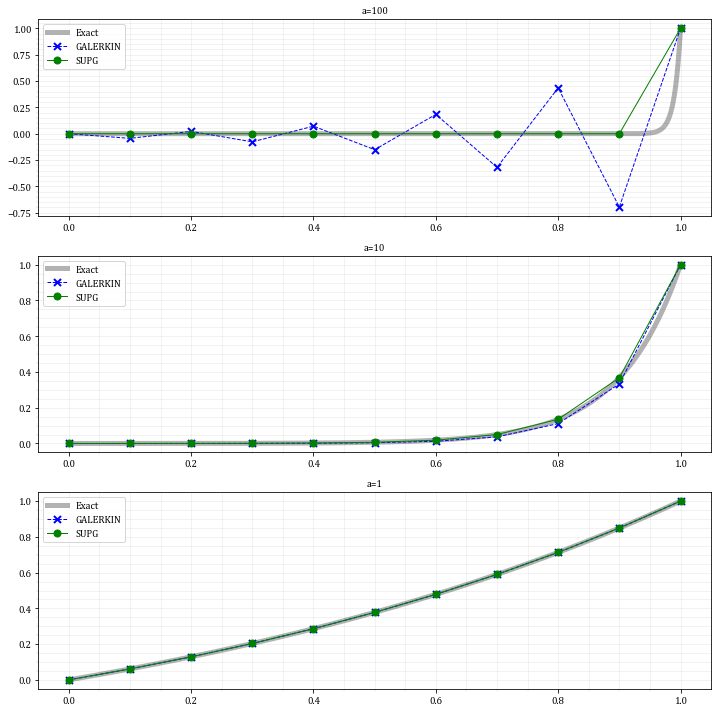

In [2]:

# GALERKIN or SUPG
METHOD = "SUPG"
KAPPA = 1
N = 10
H = 1/N
G0 = 0
G1 = 1
F = np.zeros( N-1 )

fig, [ax1, ax2, ax3] = plt.subplots( 3,1, figsize=(10,10))

# NUMERICAL SOLUTIONS
X = np.linspace( 0, 1, N+1 )
X_EXACT = np.linspace( 0, 1, 500 )
evr = 1 #int(N/20)

ax=ax1
A=100
U_EXACT = ( np.exp( A*X_EXACT) - 1 ) / ( np.exp(A) - 1)
ax.plot( X_EXACT, U_EXACT, c='k', lw=5, alpha=.3, label='Exact' )
METHOD = "GALERKIN" 
U = Usolve()
ax.plot( X[::evr], U[::evr], marker='x',markeredgewidth=2, ls='--', ms=7, lw=1, label=METHOD, c='blue' )
METHOD = "SUPG" 
U = Usolve()
ax.plot( X[::evr], U[::evr],marker='o', ms=7, ls='-', lw=1, label=METHOD, c='green' )
ax.set_title(f"a={A}")
ax.legend()

ax=ax2
A=10
U_EXACT = ( np.exp( A*X_EXACT) - 1 ) / ( np.exp(A) - 1)
ax.plot( X_EXACT, U_EXACT, c='k', lw=5, alpha=.3, label='Exact' )
METHOD = "GALERKIN" 
U = Usolve()
ax.plot( X[::evr], U[::evr], marker='x',markeredgewidth=2, ls='--', ms=7, lw=1, label=METHOD, c='blue' )
METHOD = "SUPG" 
U = Usolve()
ax.plot( X[::evr], U[::evr],marker='o', ms=7, ls='-', lw=1, label=METHOD, c='green' )
ax.set_title(f"a={A}")
ax.legend()

ax=ax3
A=1
U_EXACT = ( np.exp( A*X_EXACT) - 1 ) / ( np.exp(A) - 1)
ax.plot( X_EXACT, U_EXACT, c='k', lw=5, alpha=.3, label='Exact' )
METHOD = "GALERKIN" 
U = Usolve()
ax.plot( X[::evr], U[::evr], marker='x',markeredgewidth=2, ls='--', ms=7, lw=1, label=METHOD, c='blue' )
METHOD = "SUPG" 
U = Usolve()
ax.plot( X[::evr], U[::evr],marker='o', ms=7, ls='-', lw=1, label=METHOD, c='green' )
ax.set_title(f"a={A}")
ax.legend()

fig.tight_layout()

In [3]:
def F_update() :
    global F, H, N, A
    F = np.zeros(N+1)
    XI = XI_F()
    for EL in range(0,N) :
        N0 = EL
        N1 = EL+1
        x0 = N0 * H
        x1 = N1 * H

        def f_01(x) : return x - x**2/2/H + x0*x/H - XI*x/2
        def f_0x(x) : return x**2/2 - x**3/3/H + x0*x**2/2/H - XI*x**2/4
        def f_11(x) : return x**2/2/H - x0*x/H + XI*x/2
        def f_1x(x) : return x**3/3/H - x0*x**2/2/H + XI*x**2/4
              
        a01 = 0; a0x = 0; a11 = 0; a1x = 0
        b01 = 0; b0x = 0; b11 = 0; b1x = 0
        
        if x0 <= 3/8 :
            if x1 <= 3/8 :
                a01 = f_01(x1) - f_01(x0) 
                a0x = f_0x(x1) - f_0x(x0) 
                a11 = f_11(x1) - f_11(x0) 
                a1x = f_1x(x1) - f_1x(x0) 
            else : # partially in (3/8 - 1/2)
                a01 = f_01(3/8) - f_01(x0) 
                a0x = f_0x(3/8) - f_0x(x0) 
                a11 = f_11(3/8) - f_11(x0) 
                a1x = f_1x(3/8) - f_1x(x0) 

                b01 = f_01(x1) - f_01(3/8) 
                b0x = f_0x(x1) - f_0x(3/8) 
                b11 = f_11(x1) - f_11(3/8) 
                b1x = f_1x(x1) - f_1x(3/8) 
        elif x0 <= 1/2 :
            if x1 <= 1/2 :  # completely in (3/8 - 1/2)
                b01 = f_01(x1) - f_01(x0) 
                b0x = f_0x(x1) - f_0x(x0) 
                b11 = f_11(x1) - f_11(x0) 
                b1x = f_1x(x1) - f_1x(x0) 
            else :   # partially in (3/8 - 1/2)
                b01 = f_01(1/2) - f_01(x0) 
                b0x = f_0x(1/2) - f_0x(x0) 
                b11 = f_11(1/2) - f_11(x0) 
                b1x = f_1x(1/2) - f_1x(x0) 
        
        F[N0] += 16*A*( a01 - 4*a0x ) 
        F[N1] += 16*A*( a11 - 4*a1x )

        F[N0] += 16*A*( -2*b01 + 4*b0x ) 
        F[N1] += 16*A*( -2*b11 + 4*b1x )

    F = F[1:N] 

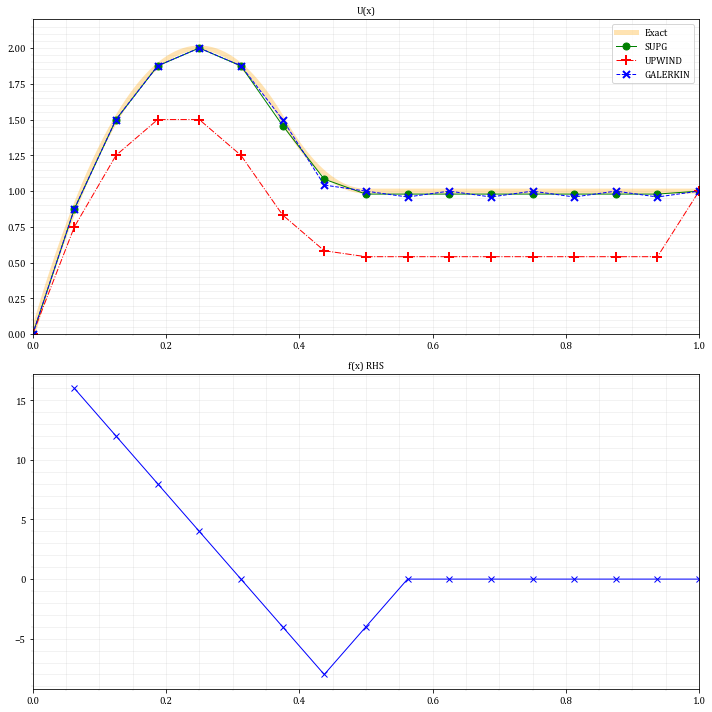

In [16]:
KAPPA = 0
N = 16
H = 1/N
A = 1
G0 = 0
G1 = 1
F = np.zeros(N-1)
F_ = np.zeros(N-1)

fig,[ax1,ax2] = plt.subplots( 2,1 , figsize=(10,10))

X_EXACT = np.linspace( 0, 1, 500 )
U_EXACT = np.zeros( 500 )
for i in range(0,500) :
    x = X_EXACT[i]
    if   x <= 3/8 :
        U_EXACT[i] = 16*x*( 1 - 2*x )
    elif x <= 1/2 :
        U_EXACT[i] = 9 + 32*x*(x-1)
    else :
        U_EXACT[i] = 1
    # print(f"x:{x} => F:{F[i]}")
ax1.plot( X_EXACT, U_EXACT, c='orange', lw=5, alpha=.3, label='Exact' )

# NUMERICAL SOLUTIONS
X = np.linspace( 0, 1, N+1 )
for i in range(0,N-1) :
    x = X[i]
    if   x <= 3/8 :
        F_[i] = 16 * A * ( 1 - 4*x )
    elif x <= 1/2 :
        F_[i] = 16 * A * (-2 + 4*x )
    else :
        F_[i] = 0
ax2.plot( X, np.insert(np.append(F_,0),0,None), marker='x', label="f(x)"  )
ax2.set_title("f(x) RHS")
evr = 1 #int(N/20)
# plt.scatter( X[::evr], U[::evr], marker='+', s=50, lw=1 )

METHOD = "SUPG" 
F_update()
U = Usolve()
ax1.plot( X[::evr], U[::evr],marker='o', ms=7, ls='-', lw=1, label=METHOD, c='green' )

METHOD = "UPWIND" 
F_update()
U = Usolve()
ax1.plot( X[::evr], U[::evr], marker='+', markeredgewidth=2, ms=10, ls='-.', lw=1, label=METHOD, c='red' )
#ax1.legend()

METHOD = "GALERKIN" 
KAPPA = 1e-15
F_update()
U = Usolve()
ax1.plot( X[::evr], U[::evr], marker='x',markeredgewidth=2, ls='--', ms=7, lw=1, label=METHOD, c='blue' )

ax1.set_title("U(x)")
ax1.set_xlim(0,1)
ax1.set_ylim(0,2.2)
ax1.legend()

ax2.set_xlim(0,1)

fig.tight_layout()
